# モデル概要

**Xceptionのファインチューニングでcifar10を分類**

In [1]:
#まずは色々インポート

%matplotlib inline
from matplotlib import pyplot as plt

import os

import keras
import numpy as np
import pandas as pd

from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib.colors import Normalize

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

random_state = 723

Using TensorFlow backend.


# データ読み込み・前処理
## 関数・クラスの定義

In [2]:
#画像を並べて表示する関数　※訓練データの内容と処理結果の確認用
def show_cifar10_images(dataset):
    fig = plt.figure(figsize=(9, 15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)
    for i in range(81):
        ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
        ax.imshow(dataset[i])

In [3]:
#Mixupクラス
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [4]:
#random erasingを実行する関数
def random_erasing(img, p = 0.5, s_l = 0.02, s_h = 0.4, r1 = 0.3, r2 = 1. / 0.3):
    p1 = np.random.uniform(0,1)
    if p1 < p:
        return img
    else:
        H = img.shape[0]
        W = img.shape[1]
        S = H * W
        while True:
            S_e = S * np.random.uniform(low=s_l, high=s_h)
            r_e = np.random.uniform(low=r1, high=r2)

            H_e = np.sqrt(S_e * r_e)
            W_e = np.sqrt(S_e / r_e)

            x_e = np.random.randint(0, W)
            y_e = np.random.randint(0, H)

            if x_e + W_e <= W and y_e + H_e <= H:
                img_erased = np.copy(img)
                img_erased[y_e:int(y_e + H_e + 1), x_e:int(x_e + W_e + 1), :] = np.random.uniform(0, 1)
                return img_erased

## 訓練データの読み込み
### 読み込み

In [5]:
#訓練画像の読み込み

def load_cifar10():
    
    # 学習データ
    x_train = np.load('data/x_train.npy')
    y_train = np.load('data/y_train.npy')

    # テストデータ
    x_test = np.load('data/x_test.npy')
    
    x_train = x_train / 255.
    x_test = x_test / 255.
    
    y_train = np.eye(10)[y_train]
    
    return (x_train, x_test, y_train)

x_train, x_test, y_train = load_cifar10()

### 読み込んだデータのshapeの確認

In [6]:
#shapeを表示
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)


## 前処理

In [7]:
#訓練データとテストデータをホワイトニング
from keras.preprocessing.image import ImageDataGenerator

gcn_whitening = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
gcn_whitening.fit(x_train)
gcn_whitening.fit(x_test)

In [8]:
#性能テスト用に1000枚避けておく
x_test2 = x_train[-1000:].copy()
y_test2 = y_train[-1000:].copy()
x_train = x_train[:-1000]
y_train = y_train[:-1000]
print(x_test2.shape)
print(y_test2.shape)
print(x_train.shape)
print(y_train.shape)

(1000, 32, 32, 3)
(1000, 10)
(49000, 32, 32, 3)
(49000, 10)


In [9]:
#画像データの水増し
datagen = ImageDataGenerator(rotation_range=22,
                            width_shift_range=0.4,
                            height_shift_range=0.3,
                            zoom_range=0.35,
                            horizontal_flip=True)
x_train_gen = x_train.copy()
x_train_gen2 = x_train.copy()
x_train_gen3 = x_train.copy()
x_train_gen4 = x_train.copy()
datagen.fit(x_train_gen)
random_state = 101
datagen.fit(x_train_gen2)
random_state = 102
datagen.fit(x_train_gen3)
random_state = 103
datagen.fit(x_train_gen4)

In [10]:
#Mixupの実行
x_train_mix = x_train.copy()
y_train_mix = y_train.copy()
gen_mixup = MixupGenerator(x_train_mix, y_train_mix, batch_size=22000, alpha=1.0 )()
x_train_mix, y_train_mix = next(gen_mixup)
print(x_train_mix.shape)
print(y_train_mix.shape)

(22000, 32, 32, 3)
(22000, 10)


In [11]:
#x_trainとy_trainに水増ししたデータをマージ
x_train = np.vstack([x_train, x_train_gen, x_train_gen2, x_train_gen3, x_train_gen3])
y_train = np.vstack([y_train, y_train, y_train, y_train, y_train])
print(x_train.shape)
print(y_train.shape)

(245000, 32, 32, 3)
(245000, 10)


In [12]:
#random erasingを実行
for i in range(x_train.shape[0]):
    x_train[i] = random_erasing(x_train[i])
print(x_train.shape)
print(y_train.shape)

(245000, 32, 32, 3)
(245000, 10)


In [13]:
#元データとMixupデータをマージ
x_train = np.vstack([x_train, x_train_mix])
y_train = np.vstack([y_train, y_train_mix])
print(x_train.shape)
print(y_train.shape)

(267000, 32, 32, 3)
(267000, 10)


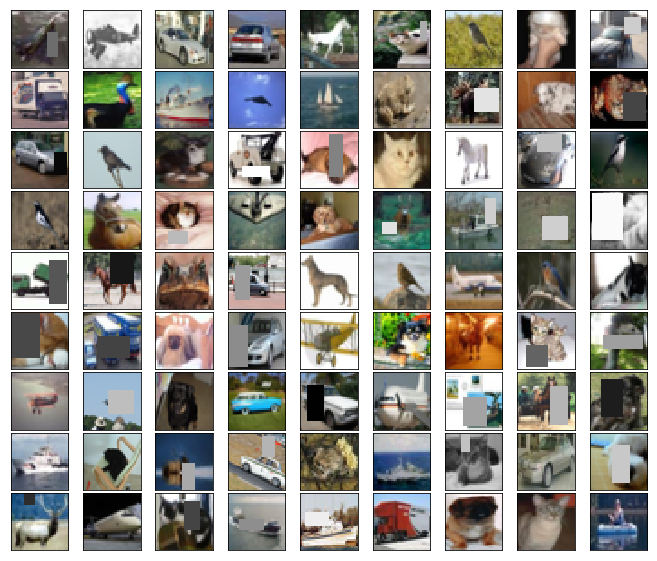

In [14]:
#random erasingの結果を表示
show_cifar10_images(x_train)

In [15]:
#プログラムの検証用に1000枚でトレーニング
x_train = x_train[:1000]
y_train = y_train[:1000]

# 学習
## 下準備

In [16]:
#モデル構築用ライブラリのインポート
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Input, Activation, add, Add, Dropout
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [17]:
#モデル保存場所と予測結果吐き出し場所
save_pass = 'result/'
save_weight = save_pass + 'weights.{epoch:03d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
subm = save_pass + 'submission.csv'

In [18]:
#メトリクスの作成　※f1とprecisionがデフォルトで実装されていないため…
def f1(y_true, y_pred): 
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives/(possible_positives + K.epsilon()) 
        return recall 

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives/(predicted_positives + K.epsilon())
        return precision 
    precision = precision(y_true, y_pred) 
    recall = recall(y_true, y_pred) 
    return 2*((precision*recall)/(precision+recall))

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives/(predicted_positives + K.epsilon())
    return precision

In [19]:
#Swish関数（活性化関数）の定義
from keras import backend as K
def swish(x):
    return x * K.sigmoid(x)

## モデル作成

In [20]:
#モデル定義
from keras.applications.xception import Xception

#モデル定義
base_model = Xception(weights='imagenet', include_top=False,
                 input_tensor=Input(shape=(32,32,3)))

#add new layers instead of FC networks
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation=swish)(x)
prediction = Dense(10, activation='softmax')(x) #10クラスに振り分ける
model = Model(inputs=base_model.input,outputs=prediction)

#コンパイル
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=['accuracy', f1])

In [21]:
# コールバック設定
from keras.callbacks import ModelCheckpoint

MAX_EPOCH = 5 #エポック数を設定する。（100以上推奨）

callbacks = []

callbacks.append(ModelCheckpoint(filepath=save_weight, monitor='val_loss', save_best_only=False, save_weights_only=True, mode='auto', period=1))

## 再学習　※再学習する時のみ使用
model.load_weights('xxx')

## 学習の開始

In [22]:
#fit
history = model.fit(x_train, y_train, batch_size=384, epochs=MAX_EPOCH, callbacks=callbacks, validation_split=0.1,  shuffle=True)

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 34s 38ms/step - loss: 2.3029 - acc: 0.0989 - f1: nan - val_loss: 2.3010 - val_acc: 0.1300 - val_f1: nan
Epoch 2/5
900/900 [==============================] - 38s 42ms/step - loss: 2.3013 - acc: 0.1167 - f1: nan - val_loss: 2.3008 - val_acc: 0.1300 - val_f1: nan
Epoch 3/5
900/900 [==============================] - 33s 37ms/step - loss: 2.3006 - acc: 0.1167 - f1: nan - val_loss: 2.3003 - val_acc: 0.1300 - val_f1: nan
Epoch 4/5
900/900 [==============================] - 31s 35ms/step - loss: 2.3000 - acc: 0.1167 - f1: nan - val_loss: 2.2996 - val_acc: 0.1300 - val_f1: nan
Epoch 5/5
900/900 [==============================] - 29s 32ms/step - loss: 2.2991 - acc: 0.1189 - f1: nan - val_loss: 2.2993 - val_acc: 0.1300 - val_f1: nan


## 学習結果の可視化

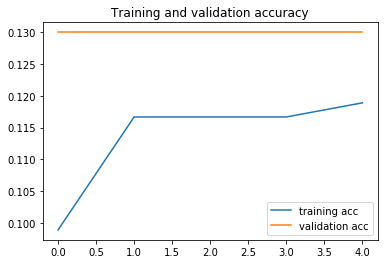

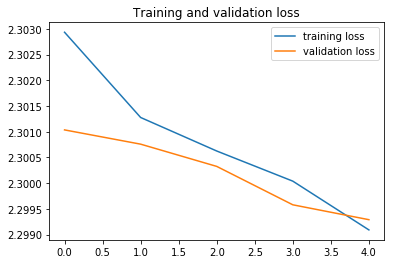

In [23]:
#学習結果を表示

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', label='training acc')
plt.plot(epochs, val_acc, '-', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 性能テスト

1000/1000 [==============================] - 5s 5ms/step
loss= 2.3027743911743164
accuracy= 0.111
1000/1000 [==============================] - 5s 5ms/step
loss= 2.3025213317871094
accuracy= 0.111
1000/1000 [==============================] - 5s 5ms/step
loss= 2.3027592105865478
accuracy= 0.113
1000/1000 [==============================] - 5s 5ms/step
loss= 2.3026846923828126
accuracy= 0.113
1000/1000 [==============================] - 5s 5ms/step
loss= 2.3032668704986574
accuracy= 0.111


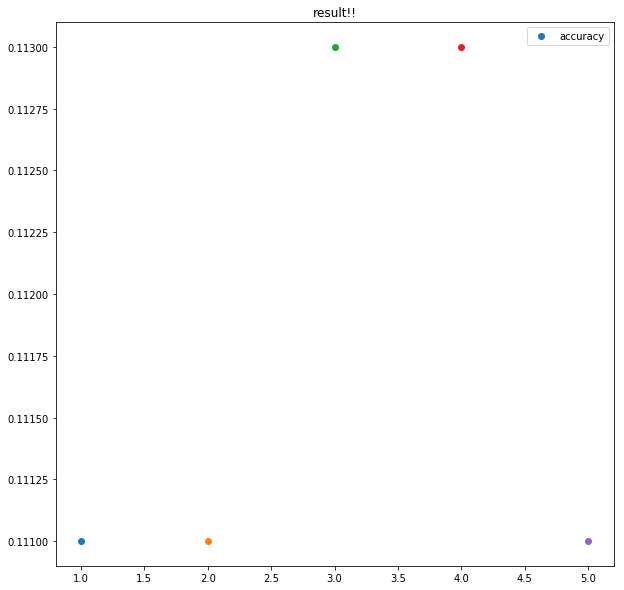

In [26]:
# エポック毎に性能評価

import glob
from pylab import rcParams

files = sorted(glob.glob(save_pass + '/*.hdf5'))
epochs = 0
rcParams['figure.figsize'] = 10, 10

for f in files:
    epochs+=1
    model.load_weights(f)
    score = model.evaluate(x=x_test2, y=y_test2)
    print('loss=', score[0])
    print('accuracy=', score[1])
    if epochs == 1:
        plt.plot(epochs, score[1], 'o', label = 'accuracy')
    else:
        plt.plot(epochs, score[1], 'o')       
plt.title('result!!')
plt.legend()
plt.show()

# 予測結果の出力

In [28]:
#最良モデルのはめ直し　※最も良かったエポックの重みをロード
model.load_weights(save_pass + 'weights.005-2.30-0.12-2.30-0.13.hdf5')

In [29]:
#予測
pred_y = model.predict(x_test)
pred_y = np.argmax(pred_y, 1)
    
submission = pd.Series(pred_y, name='label')
submission.to_csv(subm, header=True, index_label='id')